In [1]:
import numpy as np
import os
from my_rigid_kinematics import dh_robot_config
from JS_control import cacl_torque
import matplotlib.pyplot as plt
from pyrep import PyRep
from arm import CtRobot
from pyrep.backend import vrep
import sympy as sp
from pyrep.const import JointMode
import time
import cloudpickle
import control
%matplotlib notebook

pr = PyRep()

In [ ]:
control.ss

In [2]:
param = ['D', 'a', 'alpha', 'theta', 'num_joints', 'jointType', 'Tbase', 'L', 'M']
config = dict()
for i in range(len(param)):
    config[param[i]] = np.load('./robot_config/config_ct_7DOF/%s.npy'%param[i])

In [3]:
robot = dh_robot_config(int(config['num_joints']), config['alpha'], config['theta'], config['D'], config['a'], 
                                                config['jointType'], config['Tbase'], config['L'], config['M'])
robot.initKinematicTransforms()

Calculating link 0
Calculating link 1
Calculating link 2
Calculating link 3
Calculating link 4
Calculating link 5
Calculating link 6
Calculating link 7
Calculating Mass and Gravity Matrix...
-------------------------------------------------------------------
Calculation complete


In [24]:
robot._Mq[0](0,0,0,15/180*np.pi,0,0,0,0,0,0)

array([[ 6.14070146e+00, -4.94567063e-06, -6.58161503e-08,
        -8.16897236e-03,  6.53842224e-05,  1.40825392e-03,
        -1.13269526e-02],
       [-4.94567063e-06,  5.44690130e+00,  1.29651594e-01,
        -3.68718568e-08,  5.93401072e-03, -5.93804707e-09,
        -4.95925535e-08],
       [-6.58161503e-08,  1.29651594e-01,  1.62440707e+00,
         1.47582696e+00,  1.10139594e+00,  8.35580219e-01,
        -1.87959998e-05],
       [-8.16897236e-03, -3.68718568e-08,  1.47582696e+00,
         1.47793534e+00,  1.10061379e+00,  8.35179697e-01,
         5.39799197e-05],
       [ 6.53842224e-05,  5.93401072e-03,  1.10139594e+00,
         1.10061379e+00,  1.10131984e+00,  8.35582963e-01,
        -2.89850771e-05],
       [ 1.40825392e-03, -5.93804707e-09,  8.35580219e-01,
         8.35179697e-01,  8.35582963e-01,  8.35667203e-01,
        -5.39548690e-05],
       [-1.13269526e-02, -4.95925535e-08, -1.87959998e-05,
         5.39799197e-05, -2.89850771e-05, -5.39548690e-05,
         1.4910001

In [25]:
robot._Gq[0](0,0,0,15/180*np.pi,0,0,0,0,0,0)

array([[ 1.43275261e-05],
       [-6.35241303e-06],
       [-1.03770408e-02],
       [ 8.79783250e-02],
       [-1.45205247e-04],
       [-1.32844186e-02],
       [ 0.00000000e+00]])

## Simulation Set up

In [4]:
pr.launch(os.getcwd() + '/Modified_DH_ct_7DOF.ttt', headless=False)
ct_robot = CtRobot()

xyz = np.array([0, 0, 0])
err_pos = []
err_vel = []

for i in range(ct_robot._num_joints - 1):
    ct_robot.joints[i].set_joint_mode(JointMode.FORCE)
    ct_robot.arms[i].set_dynamic(True)
    ct_robot.joints[i].set_control_loop_enabled(False)
# Fixed the last joint
ct_robot.joints[-1].set_joint_mode(JointMode.PASSIVE)
ct_robot.arms[-1].set_dynamic(False)

In [59]:
# Starting simulation
pr.start()
err_pos = []
err_vel = []
# Desired trajectory
dt = 0.01
end_time = 3
t_dic = np.linspace(0, end_time, num=int(end_time/dt), endpoint=True)
t = sp.Symbol('t')
# disired trajectory of position for each joint

'''traj = [
    0.005*sp.sin(t/2),
    0.006*sp.cos(t),
    (3/180*np.pi)*sp.sin(t),
    (1/180*np.pi)*sp.sin(t/2),
    (1/180*np.pi)*sp.cos(t/2),
    (1/180*np.pi)*sp.cos(t/2),
    0.00*sp.sin(t/2)+0.00
]'''

# # Sine wave activation
# traj = [
#     0.0*sp.sin(t*4),
#     0.0*sp.cos(t*4),
#     (15/180*np.pi)*sp.sin(t*np.pi),
#     (0/180*np.pi)*sp.sin(t*4),
#     (0/180*np.pi)*sp.cos(t/2),
#     (0/180*np.pi)*sp.cos(t/2),
#     0.00*sp.sin(t/2)
# ]

# Step response
traj = [
    0.000 * sp.ones(1),
    0.000 * sp.ones(1),
    (30/180*np.pi)*sp.ones(1),
    (0/180*np.pi)*sp.ones(1),
    (0/180*np.pi)*sp.ones(1),
    (0/180*np.pi)*sp.ones(1),
    0.00*sp.ones(1)
]


pos = [sp.lambdify(t, i) for i in traj]
vel = [sp.lambdify(t, i.diff(t)) for i in traj]
acc = [sp.lambdify(t, i.diff(t).diff(t)) for i in traj]


# Gain
#kp = np.diag([30, 30, 100, 40, 80, 5, 7])
#kv = np.diag([90, 100, 5, 6, 7, 8, 9])

kp = np.diag([30, 30, 15, 0, 0, 0, 0])
kv = np.diag([0, 0, 0, 0, 0, 0, 0])
# kv[3] = 1.5 
#kv = np.diag([90, 100, 5, 0, 0, 0, 0])

# Simulation
for i in range(int(end_time/dt)):
    ts = time.time()
    posd = np.array([j(t_dic[i]) for j in pos]).squeeze()
    veld = np.array([j(t_dic[i]) for j in vel]).squeeze()
    accd = np.array([j(t_dic[i]) for j in acc]).squeeze()
    posm = np.array(ct_robot.get_joint_positions())
    velm = np.array(ct_robot.get_joint_velocities())
    tau = cacl_torque(robot, kp, kv, posd, posm, veld, velm, xyz, accd)
    print(tau[2], tau[4])
    # print('Time for computing torque: %.4f'%(time.time()-ts))
    ct_robot.set_joint_forces(tau.tolist())
    ct_robot.set_joint_target_velocities(veld.tolist())
    pr.step()
    # print('Time for Interacting with V-REP: %.4f'%(time.time()-ts))
    measure_pos = np.array(ct_robot.get_joint_positions())
    measure_vel = np.array(ct_robot.get_joint_velocities())
    
    # Record error of each joint
    err_pos.append(posd - measure_pos)
    err_vel.append(veld - measure_vel)


-0.010377050237858043 -2.530207817613211e-07
-0.018432898032163705 -0.005319044902829952
-0.009353695293405953 0.0006358611801219143
-0.009473391114003539 0.0005423757626498656
-0.009495152206383323 0.0004937040646897519
-0.009622278369174725 0.00042213109767900655
-0.00972367680752203 0.00038948503682066177
-0.00980917253557791 0.0003360950306016678
-0.009880320162301058 0.00028604875461548464
-0.009883876613339537 0.0002667813848522924
-0.01002291246478029 0.00022085910993300384
-0.009988236533206393 0.0002098916748102032
-0.010044508380844702 0.00018187514099732752
-0.010023709790908329 0.00016261572188321197
-0.010139138623903565 0.00013748478509920621
-0.010180981947636397 0.00012198052268091047
-0.010163737037964766 0.00010531151414975783
-0.010220622392522366 9.196675905989753e-05
-0.010252429853963007 8.276452872077827e-05
-0.010192112764449882 8.557354445431436e-05
-0.010268586536429126 8.08662200465466e-05
-0.010289422731995812 6.35209254947393e-05
-0.010254415880553282 4.709

-0.0104070277433522 -4.698300993255354e-06
-0.010365399499885413 6.541308073069472e-08
-0.010394470528607279 -5.5258554815356176e-06
-0.01038807554337864 -5.042793976821188e-06
-0.010400770860414145 -2.608061617751763e-06
-0.010371386578798268 2.8584989200505145e-07
-0.010359091402965316 -7.815391268961612e-07
-0.010349078445998625 -3.309255427483804e-06
-0.010359092068037826 2.9836546673290303e-06
-0.01036523316607506 1.0550376260542484e-05
-0.010378637023149326 -2.1401313241375427e-06
-0.010367208888058728 4.649321855391069e-06
-0.01036655484602451 4.656248527524917e-06
-0.010388146136126802 -1.011368454546415e-05
-0.010343573859673856 3.6975203182593335e-07
-0.010356978762719309 2.264802917266633e-06
-0.01037387279807784 -6.036796339758519e-06
-0.010368583883101396 3.3231543012640396e-06
-0.010364549555838327 -2.7402798535185793e-06
-0.010395024879115526 -9.82630409149842e-09
-0.010380395878571197 -2.833758733022824e-06
-0.010392894120579909 5.043725618991519e-07
-0.0103358338448556

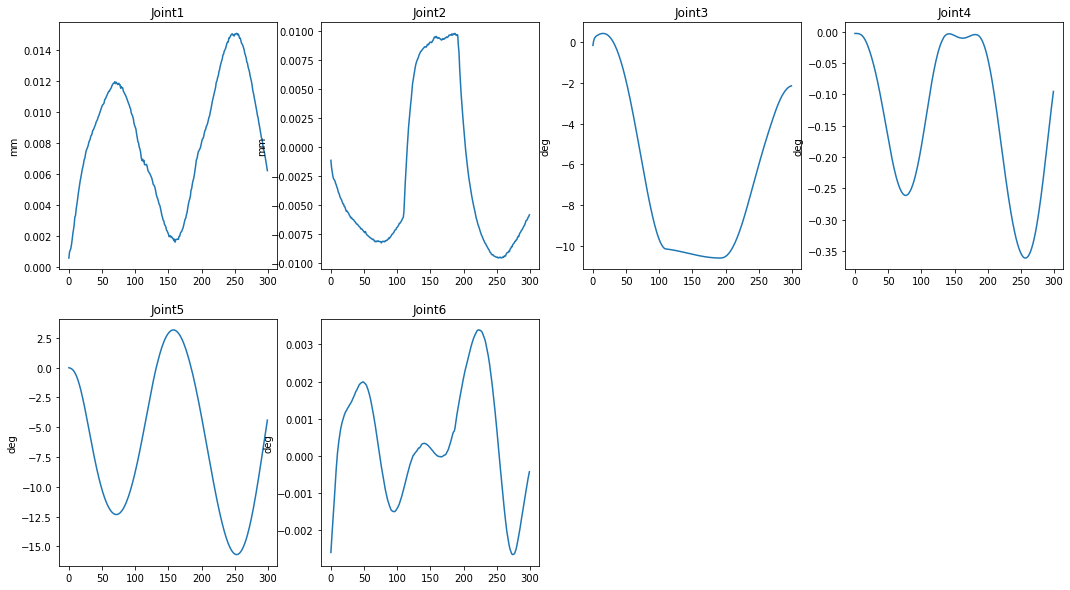

In [43]:
# Change Unit
err_pos = np.array(err_pos)
err_pos[:, 0:1] = err_pos[:, 0:1]*1000
err_pos[:, 1:2] = err_pos[:, 1:2]*1000
err_pos[:, 6:7] = err_pos[:, 6:7]*1000
err_pos[:, 2:3] = err_pos[:, 2:3]*180/np.pi
err_pos[:, 3:4] = err_pos[:, 3:4]*180/np.pi
err_pos[:, 4:5] = err_pos[:, 4:5]*180/np.pi
err_pos[:, 5:6] = err_pos[:, 5:6]*180/np.pi
# Plot error of position from joint to joint
plt.figure(figsize=(18,10))
for i in range(6):
    plt.subplot(2,4,i+1)
    plt.title('Joint%d'%(i+1))
    plt.plot(np.array(err_pos)[:, i])
    if i in [0,1,6]:
        plt.ylabel('mm')
    else:
        plt.ylabel('deg')
        
pr.stop()

err_pos = np.array(err_pos)
err_pos[:, 0:1] = err_pos[:, 0:1]*1000
err_pos[:, 1:2] = err_pos[:, 1:2]*1000
err_pos[:, 6:7] = err_pos[:, 6:7]*1000
err_pos[:, 2:3] = err_pos[:, 2:3]*180/np.pi
err_pos[:, 3:4] = err_pos[:, 3:4]*180/np.pi
err_pos[:, 4:5] = err_pos[:, 4:5]*180/np.pi
err_pos[:, 5:6] = err_pos[:, 5:6]*180/np.pi

plt.figure(figsize=(18,10))
for i in range(7):
    plt.subplot(2,4,i+1)
    plt.title('Joint%d'%(i+1))
    plt.plot(np.array(err_pos)[:, i])
    if i in [0,1,6]:
        plt.ylabel('mm')
    else:
        plt.ylabel('deg')

pr.stop()

In [ ]:
pr.shutdown()